In [151]:
import numpy as np
import pandas as pd
import os
import tqdm
import torch

from itertools import chain

import matplotlib.pyplot as plt
%matplotlib inline

In [169]:
import sys

sys.path.append('..')

import utils

from importlib import reload

reload(utils)

from utils import dataset, applier, domain, pipe, file

reload(file)
reload(dataset)
reload(applier)
reload(domain)
reload(pipe)

from utils.dataset import LabeledDataset
from utils.file import read_all_png_in_dirs

In [50]:
data_path = "/Users/sergmiller/Documents/my/IDAO-2021/data/idao_dataset/"

In [51]:
train_path = os.path.join(data_path, "train")

In [52]:
sample_dataset = dataset.build_dataset(
    [
        os.path.join(train_path,'NR'),
        os.path.join(train_path,'ER')], limit=10)

In [53]:
sample_dataset.samples.shape

(20, 576, 576)

In [30]:
test_data_g = read_all_png_in_dirs(
    [
        os.path.join(data_path, 'public_test'),
        os.path.join(data_path, 'private_test')
    ], limit=10)

In [31]:
test_data = list([x for x in test_data_g])

In [32]:
test_data

[('0c2b855c9bbdd1513b826ebdbd157ee8afa3faa9.png',
  array([[ 99, 105, 102, ..., 103, 102, 106],
         [ 99, 104, 102, ..., 103, 108,  97],
         [ 93, 101,  97, ..., 106,  98, 101],
         ...,
         [101,  97, 102, ..., 101, 102, 106],
         [ 98,  99, 100, ..., 100, 100, 102],
         [100,  99, 100, ...,  98,  98, 106]], dtype=uint8)),
 ('8f862af208004bc8f20501a122305ae9fff7d984.png',
  array([[ 98,  98, 100, ..., 100, 102, 104],
         [101, 105,  98, ...,  98,  98, 105],
         [104, 100, 101, ...,  96, 101, 103],
         ...,
         [102, 100, 101, ..., 101, 104,  98],
         [ 98, 103, 107, ...,  94, 105,  99],
         [100, 108,  98, ..., 100, 103, 102]], dtype=uint8)),
 ('60f8f137f6c65b98e5f0908844c6d60522597cca.png',
  array([[102,  98,  97, ...,  99, 101, 103],
         [ 98, 105, 103, ...,  99, 104,  99],
         [103,  99, 104, ...,  88, 102,  99],
         ...,
         [100,  97,  98, ..., 103,  98, 100],
         [ 99,  98, 103, ...,  96, 101, 

In [101]:
test_data_2 = file.read_all_png_in_dir(os.path.join(data_path, 'public_test'), limit=10)

100%|██████████| 10/10 [00:00<00:00, 119.57it/s]


In [107]:
d2 = np.array(255 * test_data_2[list(test_data_2.keys())[0]], dtype=np.uint8)

In [106]:
test_data[0]  # 0c2b855c9bbdd1513b826ebdbd157ee8afa3faa9.png

('0c2b855c9bbdd1513b826ebdbd157ee8afa3faa9.png',
 array([[ 99, 105, 102, ..., 103, 102, 106],
        [ 99, 104, 102, ..., 103, 108,  97],
        [ 93, 101,  97, ..., 106,  98, 101],
        ...,
        [101,  97, 102, ..., 101, 102, 106],
        [ 98,  99, 100, ..., 100, 100, 102],
        [100,  99, 100, ...,  98,  98, 106]], dtype=uint8))

In [108]:
d1 = test_data[0][1]

In [111]:
np.mean(d2 == d1)

1.0

In [87]:
sample_dataset.save('test.npz')
sample_dataset = dataset.LabeledDataset.load('test.npz')

In [7]:
sample_dataset.samples.shape

(10, 576, 576)

In [55]:
import torchvision.models as models
import torchvision.transforms as transforms
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
# model = models.mobilenet_v3_small(pretrained=True)

In [56]:
torch.set_num_threads(1)

In [57]:
torch.get_num_threads()

1

In [58]:
croped_mobilenet = torch.nn.Sequential(
    transforms.CenterCrop(64),
    applier.mobilenet_v3_small
)

In [59]:
croped_mobilenet.train(False)

Sequential(
  (0): CenterCrop(size=(64, 64))
  (1): MobileNetV3(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (relu): ReLU(inplace=True)
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1

In [8]:
train_dataset = dataset.build_dataset(train_path)

100%|██████████| 13404/13404 [01:37<00:00, 136.97it/s]


In [88]:
train_emb_dataset = applier.build_embd_dataset(train_dataset, croped_mobilenet)

100%|██████████| 838/838 [01:14<00:00, 11.28it/s]


In [102]:
train_emb_dataset.save('../data/center_crop_64_mobilenet_v3_small_embeddings.npz')

In [60]:
train_emb_dataset = LabeledDataset.load('../data/center_crop_64_mobilenet_v3_small_embeddings.npz')

In [61]:
train_emb_dataset.samples.shape

(13404, 1000)

In [62]:
np.sum(np.abs(train_emb_dataset.samples[0]))

2531.2258

In [140]:
def apply_random_projection_and_normalize(data : np.array, to_dim : int = 10, seed : int = 0):
    assert 2 == len(data.shape)
    np.random.seed(seed)
    N = data.shape[1]
    proj_matrix = np.random.randn(N, to_dim) / np.sqrt(N)
#     print(np.mean(proj_matrix), np.std(proj_matrix))
    data_proj = np.matmul(data, proj_matrix)
    data_proj /= np.sum(np.abs(data_proj), axis=1, keepdims=True)
    return data_proj

In [64]:
import copy
proj_emb_dataset = copy.copy(train_emb_dataset)
proj_emb_dataset.samples = apply_random_projection_and_normalize(
    train_emb_dataset.samples, to_dim=64)

-0.0001223936709412919 0.03147750951722001


In [65]:
np.sum(np.abs(proj_emb_dataset.samples[0]))

0.9999999999999999

In [66]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [50]:
build_fold = lambda seed: StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
params = {
    "penalty": 'l1',
    "solver": 'saga',
    "verbose": 10,
    "max_iter": 100,
    "tol": 1e-5,
    "scoring" : 'roc_auc',
    "random_state": 0,
    "cv": build_fold(0),
    "n_jobs": 7,
    "refit": False
}

In [51]:
ids = np.arange(len(proj_emb_dataset.samples))
np.random.seed(0)
np.random.shuffle(ids)
N = int(len(ids) * 0.9)
train_ids = ids[:N]
val_ids = ids[N:]
print(train_ids[:10], val_ids[:10])

[10869  3245 13299 10980  1103  5091 10134  6859  4516  4422] [ 1057 10013  6979  7505    60  6173  4878    35 11686  7315]


In [401]:
!pip3 install pytorch-lightning

     |████████████████████████████████| 829 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 14.1 MB/s eta 0:00:01
     |████████████████████████████████| 10.6 MB 3.2 MB/s eta 0:00:01    |███████████                     | 3.6 MB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 136 kB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 9.3 MB/s  eta 0:00:01
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.1.0-py2.py3-none-any.whl (147 kB)
     |████████████████████████████████| 781 kB 10.7 MB/s eta 0:00:01
  Using cached Werkzeug-1.0.1-py2.py3-none-any.whl (298 kB)
     |████████████████████████████████| 649 kB 9.1 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 2.9 MB/s eta 0:00:0

In [52]:
train_proj_emb_dataset = proj_emb_dataset.subset(train_ids)
val_proj_emb_dataset = proj_emb_dataset.subset(val_ids)

In [53]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
import pytorch_lightning as pl

In [31]:
class TrainableModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(32, 64), nn.Dropout(p=0.1), nn.ReLU())
        self.model_learn = nn.Sequential(self.model, nn.Linear(64, 1))
        self.model_forget = nn.Sequential(self.model, nn.Linear(64, 6))
        self.alpha = 0.1

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x, y, forget = batch
        x = x.float()
        forget = forget.long()
        z = self.model_learn(x).reshape(-1, 1)
        logits = self.model_forget(x)
        logits = logits.reshape(-1, 6)
        forget = forget.reshape(-1)
#         print(logits.shape, forget.shape)
        loss_forget = CrossEntropyLoss()(input=logits, target=forget)
        loss = BCEWithLogitsLoss()(input=z, target=y.float())
        loss -= loss_forget * self.alpha
        self.log('learn_loss', loss)
        self.log('forget_loss ', loss_forget)
        total = loss + loss_forget
        return total
    
#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         self.model.train(False)
#         with torch.no_grad():
#             z = self.model(x.float()).reshape(-1, 1)
#             y = y.reshape(-1,1).float()
#             loss = BCEWithLogitsLoss()(input=z, target=y)
#         self.log('val_loss', loss)
#         self.model.train(True)
#         return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer

In [32]:
class LightningDataset(dataset.LabeledDataset):
    def __init__(self):
        super().__init__()
        self.classes = [1, 10, 20, 3, 30, 6]
        self.class2id = {str(c) : i for i,c in enumerate(self.classes)}

    def init(self, d):
        self.tags = d.tags
        self.samples = d.samples
        self.labels = d.labels
        return self
    def __len__(self):
        return len(self.tags)
    
    def __getitem__(self, i):
        s = i
        f = (i + 1)
        x = self.samples[s:f]
        y = (self.labels[s:f, 0] == 'NR').astype(int)
        z = np.array([self.class2id[self.labels[s][1]]]).astype(int)
        return (x, y ,z)

In [33]:
B = 32
model1 = TrainableModel()
trainer = pl.Trainer(max_epochs=1,)
trainer.fit(model1, 
            DataLoader(LightningDataset().init(train_proj_emb_dataset),
                       batch_size=B, shuffle=True)
)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 2.1 K 
1 | model_learn  | Sequential | 2.2 K 
2 | model_forget | Sequential | 2.5 K 
--------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
/usr/local/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

In [522]:
torch.Tensor([1,2,3])

tensor([1., 2., 3.])

In [597]:
trainer.model.train(False)
with torch.no_grad():
    val_pred = F.sigmoid(trainer.model(
    torch.Tensor(val_proj_emb_dataset.samples))).detach().numpy()

/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [544]:
l = list(trainer.model.modules())[1][0]

(array([14., 12.,  4., 66.,  8., 23.,  0.,  0.,  0.,  1.]),
 array([-2.9786417 , -2.0764499 , -1.1742581 , -0.27206632,  0.63012546,
         1.5323173 ,  2.434509  ,  3.336701  ,  4.2388926 ,  5.1410847 ,
         6.0432763 ], dtype=float32),
 <BarContainer object of 10 artists>)

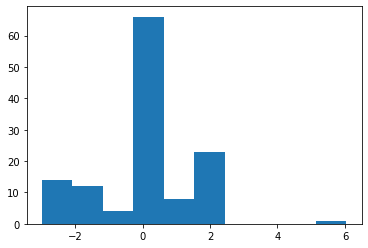

In [557]:
plt.hist(
    list(trainer.model.modules())[1][2]._parameters['weight'].detach().numpy().reshape(-1))

In [598]:
roc_auc_score(y_score=val_pred, y_true=val_proj_emb_dataset.labels[:, 0] == 'NR')

0.9590775597383527

In [300]:
import catboost

In [11]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [398]:
c_model = LogisticRegression(
    verbose=1,
    C=1000,
    max_iter=100,
    tol=1e-5,
    intercept_scaling=10000,
    solver='saga').fit(train_proj_emb_dataset.samples,
            (train_proj_emb_dataset.labels[:, 0] == 'NR').astype(int))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [399]:
c_model.coef_

array([[ -89.39231764,  -62.35505648,  -21.38688895,   93.06853924,
          54.32501979, -100.63990137,   89.1827941 ,   28.73811385,
          48.93773794,   44.34177382, -118.24216216, -130.94426432,
         -60.0413207 ,   31.77852078,  -53.66576434,    9.51406708,
         -53.20438636,   69.44730909,  -30.38905744,    0.96624803,
         -79.64019924,  -29.20501449,  -51.81416968,  100.04971752,
         -83.76852194]])

In [400]:
roc_auc_score(y_score=c_model.predict_proba(val_proj_emb_dataset.samples)[:, 1],
              y_true=(val_proj_emb_dataset.labels[:, 0] == 'NR').astype(int))

0.9502514128064788

In [361]:
c_model.get_params()

{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 10,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'saga',
 'tol': 1e-300,
 'verbose': 1,
 'warm_start': False}

In [308]:
catboost.CatBoostClassifier(custom_loss='AUC').fit(
    X=train_proj_emb_dataset.samples,
    y=(train_proj_emb_dataset.labels[:, 0] == 'NR').astype(int),
    eval_set=(
        val_proj_emb_dataset.samples,
        (val_proj_emb_dataset.labels[:, 0] == 'NR').astype(int)
    )
)

Learning rate set to 0.058618
0:	learn: 0.6233149	test: 0.6237224	best: 0.6237224 (0)	total: 25.4ms	remaining: 25.3s
1:	learn: 0.5684346	test: 0.5696975	best: 0.5696975 (1)	total: 43.3ms	remaining: 21.6s
2:	learn: 0.5275043	test: 0.5288272	best: 0.5288272 (2)	total: 60.9ms	remaining: 20.2s
3:	learn: 0.4946424	test: 0.4962000	best: 0.4962000 (3)	total: 77.3ms	remaining: 19.3s
4:	learn: 0.4678804	test: 0.4700168	best: 0.4700168 (4)	total: 93.4ms	remaining: 18.6s
5:	learn: 0.4451077	test: 0.4481566	best: 0.4481566 (5)	total: 107ms	remaining: 17.7s
6:	learn: 0.4269370	test: 0.4301235	best: 0.4301235 (6)	total: 125ms	remaining: 17.7s
7:	learn: 0.4133329	test: 0.4169449	best: 0.4169449 (7)	total: 147ms	remaining: 18.2s
8:	learn: 0.3976501	test: 0.4017889	best: 0.4017889 (8)	total: 162ms	remaining: 17.9s
9:	learn: 0.3829185	test: 0.3872968	best: 0.3872968 (9)	total: 179ms	remaining: 17.7s
10:	learn: 0.3733749	test: 0.3780247	best: 0.3780247 (10)	total: 194ms	remaining: 17.4s
11:	learn: 0.3655

99:	learn: 0.1948734	test: 0.2288419	best: 0.2288419 (99)	total: 1.86s	remaining: 16.7s
100:	learn: 0.1941326	test: 0.2282836	best: 0.2282836 (100)	total: 1.88s	remaining: 16.8s
101:	learn: 0.1935876	test: 0.2277832	best: 0.2277832 (101)	total: 1.9s	remaining: 16.7s
102:	learn: 0.1930628	test: 0.2274017	best: 0.2274017 (102)	total: 1.92s	remaining: 16.7s
103:	learn: 0.1925197	test: 0.2271114	best: 0.2271114 (103)	total: 1.93s	remaining: 16.7s
104:	learn: 0.1918435	test: 0.2268061	best: 0.2268061 (104)	total: 1.96s	remaining: 16.7s
105:	learn: 0.1912934	test: 0.2263004	best: 0.2263004 (105)	total: 1.98s	remaining: 16.7s
106:	learn: 0.1910421	test: 0.2263067	best: 0.2263004 (105)	total: 2s	remaining: 16.7s
107:	learn: 0.1906132	test: 0.2260196	best: 0.2260196 (107)	total: 2.01s	remaining: 16.6s
108:	learn: 0.1900150	test: 0.2255853	best: 0.2255853 (108)	total: 2.02s	remaining: 16.5s
109:	learn: 0.1893702	test: 0.2253203	best: 0.2253203 (109)	total: 2.04s	remaining: 16.5s
110:	learn: 0.18

196:	learn: 0.1517613	test: 0.2135866	best: 0.2135866 (196)	total: 3.5s	remaining: 14.3s
197:	learn: 0.1513046	test: 0.2135589	best: 0.2135589 (197)	total: 3.52s	remaining: 14.3s
198:	learn: 0.1509085	test: 0.2136722	best: 0.2135589 (197)	total: 3.53s	remaining: 14.2s
199:	learn: 0.1505057	test: 0.2136263	best: 0.2135589 (197)	total: 3.55s	remaining: 14.2s
200:	learn: 0.1501960	test: 0.2133883	best: 0.2133883 (200)	total: 3.56s	remaining: 14.2s
201:	learn: 0.1497334	test: 0.2134341	best: 0.2133883 (200)	total: 3.58s	remaining: 14.1s
202:	learn: 0.1492741	test: 0.2132664	best: 0.2132664 (202)	total: 3.59s	remaining: 14.1s
203:	learn: 0.1488329	test: 0.2130344	best: 0.2130344 (203)	total: 3.61s	remaining: 14.1s
204:	learn: 0.1484407	test: 0.2129820	best: 0.2129820 (204)	total: 3.62s	remaining: 14.1s
205:	learn: 0.1479583	test: 0.2128520	best: 0.2128520 (205)	total: 3.64s	remaining: 14s
206:	learn: 0.1473753	test: 0.2125008	best: 0.2125008 (206)	total: 3.65s	remaining: 14s
207:	learn: 0.1

291:	learn: 0.1200920	test: 0.2072322	best: 0.2071631 (287)	total: 4.93s	remaining: 12s
292:	learn: 0.1197331	test: 0.2072490	best: 0.2071631 (287)	total: 4.95s	remaining: 11.9s
293:	learn: 0.1194808	test: 0.2072443	best: 0.2071631 (287)	total: 4.96s	remaining: 11.9s
294:	learn: 0.1191110	test: 0.2071185	best: 0.2071185 (294)	total: 4.98s	remaining: 11.9s
295:	learn: 0.1188170	test: 0.2071568	best: 0.2071185 (294)	total: 4.99s	remaining: 11.9s
296:	learn: 0.1185410	test: 0.2070931	best: 0.2070931 (296)	total: 5.01s	remaining: 11.9s
297:	learn: 0.1182119	test: 0.2071433	best: 0.2070931 (296)	total: 5.02s	remaining: 11.8s
298:	learn: 0.1178210	test: 0.2069327	best: 0.2069327 (298)	total: 5.04s	remaining: 11.8s
299:	learn: 0.1175767	test: 0.2070701	best: 0.2069327 (298)	total: 5.05s	remaining: 11.8s
300:	learn: 0.1173830	test: 0.2069804	best: 0.2069327 (298)	total: 5.07s	remaining: 11.8s
301:	learn: 0.1170931	test: 0.2071936	best: 0.2069327 (298)	total: 5.08s	remaining: 11.8s
302:	learn: 

388:	learn: 0.0967582	test: 0.2036127	best: 0.2036127 (388)	total: 6.79s	remaining: 10.7s
389:	learn: 0.0965262	test: 0.2036709	best: 0.2036127 (388)	total: 6.81s	remaining: 10.6s
390:	learn: 0.0963683	test: 0.2035555	best: 0.2035555 (390)	total: 6.82s	remaining: 10.6s
391:	learn: 0.0962184	test: 0.2035536	best: 0.2035536 (391)	total: 6.83s	remaining: 10.6s
392:	learn: 0.0959652	test: 0.2034698	best: 0.2034698 (392)	total: 6.84s	remaining: 10.6s
393:	learn: 0.0958087	test: 0.2035422	best: 0.2034698 (392)	total: 6.86s	remaining: 10.5s
394:	learn: 0.0956353	test: 0.2036139	best: 0.2034698 (392)	total: 6.87s	remaining: 10.5s
395:	learn: 0.0954303	test: 0.2036810	best: 0.2034698 (392)	total: 6.88s	remaining: 10.5s
396:	learn: 0.0951723	test: 0.2036294	best: 0.2034698 (392)	total: 6.89s	remaining: 10.5s
397:	learn: 0.0949784	test: 0.2034841	best: 0.2034698 (392)	total: 6.91s	remaining: 10.4s
398:	learn: 0.0947173	test: 0.2035383	best: 0.2034698 (392)	total: 6.92s	remaining: 10.4s
399:	learn

480:	learn: 0.0798872	test: 0.2015010	best: 0.2015010 (480)	total: 8.01s	remaining: 8.64s
481:	learn: 0.0796965	test: 0.2015882	best: 0.2015010 (480)	total: 8.02s	remaining: 8.62s
482:	learn: 0.0795630	test: 0.2015307	best: 0.2015010 (480)	total: 8.03s	remaining: 8.6s
483:	learn: 0.0794437	test: 0.2015904	best: 0.2015010 (480)	total: 8.04s	remaining: 8.58s
484:	learn: 0.0792385	test: 0.2014489	best: 0.2014489 (484)	total: 8.06s	remaining: 8.55s
485:	learn: 0.0790899	test: 0.2015613	best: 0.2014489 (484)	total: 8.07s	remaining: 8.53s
486:	learn: 0.0789272	test: 0.2014133	best: 0.2014133 (486)	total: 8.08s	remaining: 8.51s
487:	learn: 0.0788139	test: 0.2013732	best: 0.2013732 (487)	total: 8.09s	remaining: 8.49s
488:	learn: 0.0786984	test: 0.2013810	best: 0.2013732 (487)	total: 8.1s	remaining: 8.46s
489:	learn: 0.0784827	test: 0.2014014	best: 0.2013732 (487)	total: 8.11s	remaining: 8.44s
490:	learn: 0.0783014	test: 0.2012525	best: 0.2012525 (490)	total: 8.12s	remaining: 8.42s
491:	learn: 

576:	learn: 0.0657891	test: 0.1987706	best: 0.1986583 (575)	total: 9.25s	remaining: 6.78s
577:	learn: 0.0656829	test: 0.1987793	best: 0.1986583 (575)	total: 9.26s	remaining: 6.76s
578:	learn: 0.0655503	test: 0.1987281	best: 0.1986583 (575)	total: 9.28s	remaining: 6.75s
579:	learn: 0.0654326	test: 0.1987309	best: 0.1986583 (575)	total: 9.3s	remaining: 6.73s
580:	learn: 0.0653087	test: 0.1986370	best: 0.1986370 (580)	total: 9.31s	remaining: 6.71s
581:	learn: 0.0651735	test: 0.1986026	best: 0.1986026 (581)	total: 9.33s	remaining: 6.7s
582:	learn: 0.0650857	test: 0.1986022	best: 0.1986022 (582)	total: 9.34s	remaining: 6.68s
583:	learn: 0.0649964	test: 0.1985450	best: 0.1985450 (583)	total: 9.36s	remaining: 6.66s
584:	learn: 0.0648877	test: 0.1983474	best: 0.1983474 (584)	total: 9.37s	remaining: 6.65s
585:	learn: 0.0647759	test: 0.1982338	best: 0.1982338 (585)	total: 9.38s	remaining: 6.63s
586:	learn: 0.0646469	test: 0.1982134	best: 0.1982134 (586)	total: 9.4s	remaining: 6.61s
587:	learn: 0

669:	learn: 0.0552161	test: 0.1977098	best: 0.1977098 (669)	total: 10.7s	remaining: 5.25s
670:	learn: 0.0551282	test: 0.1976571	best: 0.1976571 (670)	total: 10.7s	remaining: 5.24s
671:	learn: 0.0549918	test: 0.1977479	best: 0.1976571 (670)	total: 10.7s	remaining: 5.22s
672:	learn: 0.0548961	test: 0.1976726	best: 0.1976571 (670)	total: 10.7s	remaining: 5.2s
673:	learn: 0.0548138	test: 0.1976372	best: 0.1976372 (673)	total: 10.7s	remaining: 5.19s
674:	learn: 0.0546965	test: 0.1977984	best: 0.1976372 (673)	total: 10.7s	remaining: 5.17s
675:	learn: 0.0545671	test: 0.1978818	best: 0.1976372 (673)	total: 10.8s	remaining: 5.16s
676:	learn: 0.0545027	test: 0.1978368	best: 0.1976372 (673)	total: 10.8s	remaining: 5.14s
677:	learn: 0.0544125	test: 0.1978466	best: 0.1976372 (673)	total: 10.8s	remaining: 5.13s
678:	learn: 0.0543304	test: 0.1978144	best: 0.1976372 (673)	total: 10.8s	remaining: 5.11s
679:	learn: 0.0542112	test: 0.1978089	best: 0.1976372 (673)	total: 10.8s	remaining: 5.09s
680:	learn:

769:	learn: 0.0458933	test: 0.1976159	best: 0.1971553 (757)	total: 12.3s	remaining: 3.67s
770:	learn: 0.0458090	test: 0.1976278	best: 0.1971553 (757)	total: 12.3s	remaining: 3.66s
771:	learn: 0.0457312	test: 0.1974820	best: 0.1971553 (757)	total: 12.3s	remaining: 3.64s
772:	learn: 0.0456535	test: 0.1973917	best: 0.1971553 (757)	total: 12.4s	remaining: 3.63s
773:	learn: 0.0455737	test: 0.1973337	best: 0.1971553 (757)	total: 12.4s	remaining: 3.61s
774:	learn: 0.0454890	test: 0.1973893	best: 0.1971553 (757)	total: 12.4s	remaining: 3.6s
775:	learn: 0.0453770	test: 0.1973583	best: 0.1971553 (757)	total: 12.4s	remaining: 3.58s
776:	learn: 0.0452802	test: 0.1972566	best: 0.1971553 (757)	total: 12.4s	remaining: 3.56s
777:	learn: 0.0452068	test: 0.1974076	best: 0.1971553 (757)	total: 12.4s	remaining: 3.55s
778:	learn: 0.0451423	test: 0.1974596	best: 0.1971553 (757)	total: 12.5s	remaining: 3.53s
779:	learn: 0.0450826	test: 0.1975256	best: 0.1971553 (757)	total: 12.5s	remaining: 3.52s
780:	learn:

871:	learn: 0.0382684	test: 0.1979159	best: 0.1971553 (757)	total: 14s	remaining: 2.05s
872:	learn: 0.0382073	test: 0.1978913	best: 0.1971553 (757)	total: 14s	remaining: 2.04s
873:	learn: 0.0381376	test: 0.1979637	best: 0.1971553 (757)	total: 14s	remaining: 2.02s
874:	learn: 0.0380621	test: 0.1979340	best: 0.1971553 (757)	total: 14.1s	remaining: 2.01s
875:	learn: 0.0379925	test: 0.1979871	best: 0.1971553 (757)	total: 14.1s	remaining: 1.99s
876:	learn: 0.0379238	test: 0.1980826	best: 0.1971553 (757)	total: 14.1s	remaining: 1.98s
877:	learn: 0.0378173	test: 0.1982534	best: 0.1971553 (757)	total: 14.1s	remaining: 1.96s
878:	learn: 0.0377433	test: 0.1981496	best: 0.1971553 (757)	total: 14.1s	remaining: 1.94s
879:	learn: 0.0376771	test: 0.1981372	best: 0.1971553 (757)	total: 14.1s	remaining: 1.93s
880:	learn: 0.0376166	test: 0.1982187	best: 0.1971553 (757)	total: 14.2s	remaining: 1.91s
881:	learn: 0.0375337	test: 0.1983320	best: 0.1971553 (757)	total: 14.2s	remaining: 1.9s
882:	learn: 0.037

963:	learn: 0.0326026	test: 0.1992496	best: 0.1971553 (757)	total: 15.4s	remaining: 577ms
964:	learn: 0.0325685	test: 0.1991269	best: 0.1971553 (757)	total: 15.5s	remaining: 561ms
965:	learn: 0.0325250	test: 0.1992098	best: 0.1971553 (757)	total: 15.5s	remaining: 545ms
966:	learn: 0.0324850	test: 0.1992911	best: 0.1971553 (757)	total: 15.5s	remaining: 529ms
967:	learn: 0.0324202	test: 0.1993553	best: 0.1971553 (757)	total: 15.5s	remaining: 513ms
968:	learn: 0.0323702	test: 0.1992778	best: 0.1971553 (757)	total: 15.5s	remaining: 496ms
969:	learn: 0.0323270	test: 0.1992025	best: 0.1971553 (757)	total: 15.5s	remaining: 480ms
970:	learn: 0.0322661	test: 0.1992196	best: 0.1971553 (757)	total: 15.5s	remaining: 464ms
971:	learn: 0.0322113	test: 0.1992704	best: 0.1971553 (757)	total: 15.6s	remaining: 448ms
972:	learn: 0.0321627	test: 0.1993059	best: 0.1971553 (757)	total: 15.6s	remaining: 432ms
973:	learn: 0.0321161	test: 0.1993865	best: 0.1971553 (757)	total: 15.6s	remaining: 416ms
974:	learn

In [54]:
cv_label1 = LogisticRegressionCV(**params).fit(
    X=proj_emb_dataset.samples,
    y=(proj_emb_dataset.labels[:, 0] == 'NR').astype(int))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds


convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 7 epochs took 0 seconds
convergence after 7 epochs took 0 seconds
convergence after 7 epochs took 0 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds
max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
max_iter reached after 2 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
max_iter reached after 2 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 secondsmax_iter reached after 2 seconds

convergence after 3 epochs took 0 seconds
convergence after 1 epochs took 0 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:   12.3s remaining:   28.8s
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 9 epochs took 0 secondsconvergence after 1 epochs took 0 seconds

max_iter reached after 2 seconds
convergence after 7 epochs took 0 seconds
convergence after 9 epochs took 0 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   5 out of  10 | elapsed:   12.4s remaining:   12.4s


max_iter reached after 1 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   7 out of  10 | elapsed:   12.7s remaining:    5.4s


max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 1 seconds
max_iter reached after 2 seconds
max_iter reached after 2 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:   19.0s finished


In [55]:
import pickle

In [56]:
# save
with open('cv_label1.pkl','wb') as f:
    pickle.dump(cv_label1,f)

In [57]:
np.mean(cv_label1.scores_[1],axis=0)  # with crop64 normalized random cv=10

array([0.5       , 0.5       , 0.5       , 0.5       , 0.93023088,
       0.96280139, 0.97065471, 0.97365269, 0.97517425, 0.9761071 ])

In [232]:
np.mean(cv_label1.scores_[1],axis=0)  # with crop64 normalized random cv=10

array([0.5       , 0.5       , 0.5       , 0.70546698, 0.9175677 ,
       0.95809902, 0.96694732, 0.97029197, 0.9720148 , 0.97301826])

In [111]:
np.mean(cv_label1.scores_[1],axis=0)  # with crop64 normalized

array([0.5       , 0.5       , 0.5       , 0.70550071, 0.91753139,
       0.95811081, 0.96693674, 0.97036226, 0.97211698, 0.97315119])

In [96]:
np.mean(cv_label1.scores_[1],axis=0)  # with crop64

array([0.5       , 0.78958939, 0.93599517, 0.96792367, 0.97494673,
       0.97596747, 0.97633959, 0.97650932, 0.97657727, 0.97661092])

In [127]:
np.mean(cv_label1.scores_[1], axis=0)  # new

array([0.5       , 0.5       , 0.76982608, 0.86866077, 0.9326519 ,
       0.94429291, 0.94827148, 0.95034892, 0.95169425, 0.9526548 ])

In [124]:
np.mean(cv_label1.scores_[1], axis=0)  # old

array([0.5       , 0.5       , 0.7952889 , 0.87402804, 0.94469283,
       0.95739159, 0.96157609, 0.96381906, 0.96529288, 0.96639186])

In [24]:
cv_label1.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': 7,
 'penalty': 'l2',
 'random_state': 0,
 'refit': False,
 'scoring': 'roc_auc',
 'solver': 'saga',
 'tol': 1e-05,
 'verbose': 10}

In [41]:
scals = np.sum(cv_label1.coef_ * proj_emb_dataset.samples, axis=1) \
    / np.sum(cv_label1.coef_ ** 2) ** 0.5

(array([  12.,   52.,  246.,  634., 1243., 1907., 3041., 4049., 2039.,
         181.]),
 array([-0.05156572, -0.04595174, -0.04033775, -0.03472377, -0.02910979,
        -0.0234958 , -0.01788182, -0.01226784, -0.00665385, -0.00103987,
         0.00457412]),
 <BarContainer object of 10 artists>)

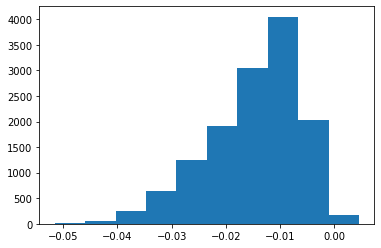

In [42]:
plt.hist(scals)

In [170]:
from sklearn.linear_model import LassoCV, LassoLarsCV, LogisticRegressionCV

In [162]:
!pip install catboost
import catboost

     |████████████████████████████████| 11.1 MB 8.8 MB/s eta 0:00:01    |███                             | 1.1 MB 2.3 MB/s eta 0:00:05
  Using cached graphviz-0.16-py2.py3-none-any.whl (19 kB)
     |████████████████████████████████| 13.2 MB 3.6 MB/s eta 0:00:01
  Using cached retrying-1.3.3.tar.gz (10 kB)
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=7142ea69f2bdc9e51212c74b906d77f6f989793d634af1c973839d25de34a510
  Stored in directory: /Users/sergmiller/Library/Caches/pip/wheels/ce/18/7f/e9527e3e66db1456194ac7f61eb3211068c409edceecff2d31
Successfully built retrying
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [78]:
classes = [1, 10, 20, 3, 30, 6]

def mae_scorer(estimator, X, y):
#     y_pred = np.array([sum(z * classes[i] for i,z in enumerate(_y)) for _y in estimator.predict_proba(X)])
    y_pred = np.array([classes[int(_y)] for _y in estimator.predict(X)])
    y = np.array([classes[_y] for _y in y])
    return -np.mean(np.abs(y_pred - y))

In [58]:
import copy

params2 = copy.copy(params)

params2['cv'] = build_fold(1)
params2['scoring'] = mae_scorer
# params2['penalty'] = 'l1'

# params2['class_weight'] = {str(c) : c for c in classes}
cv_label2 = LogisticRegressionCV(**params2).fit(
    proj_emb_dataset.samples,
    proj_emb_dataset.labels[:, 1])

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 98 epochs took 5 seconds
convergence after 100 epochs took 5 seconds
max_iter reached after 5 second

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 5 seconds
convergence after 100 epochs took 5 seconds
max_iter reached after 5 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds
max_iter reached after 4 seconds
max_iter reached after 4 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds
max_iter reached after 4 seconds
max_iter reached after 4 seconds
max_iter reached after 4 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds
max_iter reached after 4 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 6 seconds
max_iter reached after 7 seconds
max_iter reached after 6 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 6 seconds
max_iter reached after 6 seconds
max_iter reached after 6 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 6 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 7 seconds
max_iter reached after 6 seconds
max_iter reached after 6 seconds
max_iter reached after 6 seconds
max_iter reached after 6 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

max_iter reached after 6 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 7 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 7 seconds
max_iter reached after 6 seconds
max_iter reached after 7 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 7 seconds
convergence after 1 epochs took 0 seconds
max_iter reached after 7 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 1 epochs took 0 seconds
max_iter reached after 7 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
max_iter reached after 7 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:   40.7s remaining:  1.6min
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
max_iter reached after 7 seconds
max_iter reached after 7 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   5 out of  10 | elapsed:   41.1s remaining:   41.1s
[Parallel(n_jobs=7)]: Done   7 out of  10 | elapsed:   41.1s remaining:   17.6s


max_iter reached after 7 seconds
convergence after 100 epochs took 4 seconds
max_iter reached after 4 seconds
convergence after 99 epochs took 4 seconds
convergence after 99 epochs took 4 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 2 seconds
max_iter reached after 3 seconds
max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds
max_iter reached after 3 seconds
max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds
max_iter reached after 3 seconds
max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds
max_iter reached after 4 seconds
max_iter reached after 4 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 3 seconds
max_iter reached after 3 seconds
max_iter reached after 3 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:  1.1min finished


In [59]:
np.mean(cv_label2.scores_['1'],axis=0) # crop64 proj normalized random cv=10

array([-10.92192026, -12.54789041, -10.79639387,  -4.73322721,
        -1.67205266,  -0.88369868,  -0.61855282,  -0.53164407,
        -0.49270126,  -0.46286109])

In [60]:
# save
with open('cv_label2.pkl','wb') as f:
    pickle.dump(cv_label2,f)

In [172]:
np.mean(cv_label2.scores_['1'],axis=0) # crop64 proj normalized

array([-17.42117233, -10.81699934,  -8.40923982,  -3.90688966,
        -1.49081772,  -0.79319794,  -0.61772669,  -0.56096464,
        -0.53365644,  -0.51455953])

In [136]:
np.mean(cv_label2.scores_['1'],axis=0) # crop64 proj normalized prob weighted

array([-10.76203842,  -9.08192111,  -8.67627585,  -7.93668639,
        -3.32040689,  -1.61058029,  -1.13415802,  -0.98432688,
        -0.91080838,  -0.86552122])

In [114]:
np.mean(cv_label2.scores_['1'],axis=0) # crop64 proj normalized

array([-17.42117233, -10.81699934,  -8.40923982,  -3.90688966,
        -1.49081772,  -0.79319794,  -0.61772669,  -0.56096464,
        -0.53365644,  -0.51455953])

In [46]:
np.mean(cv_label2.scores_['1'],axis=0) # crop64 proj

array([-8.3034167 , -2.87024781, -1.16681787, -0.68667234, -0.50216841,
       -0.46188559, -0.43882784, -0.42890286, -0.42718655, -0.43352677])

In [24]:
np.mean(cv_label2.scores_['1'],axis=0) # mini weighted

array([7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.7, 5.7, 5.7, 5.7])

In [130]:
np.mean(cv_label2.scores_['1'],axis=0) # not weighted proj

array([-9.31475597, -8.29894242, -2.84744388, -1.16951128, -0.74142058,
       -0.62891488, -0.60055984, -0.58071633, -0.56407921, -0.55960338])

In [142]:
np.mean(cv_label2.scores_['1'],axis=0) # not weighted

array([10.68017027, 10.68017027, 10.09729052,  9.80483741,  9.63690119,
        9.57527796,  9.54491318,  9.53208126,  9.52514296,  9.51149031])

In [144]:
np.mean(cv_label2.scores_['1'],axis=0) # weighted

array([ 9.59965186,  9.4570564 ,  9.96051226, 10.08321655,  9.88160343,
        9.84861552,  9.80512292,  9.85751204,  9.71321238,  9.77365697])

In [70]:
pub_test_dataset = dataset.build_dataset(
    [os.path.join(data_path, "public_test")],
    sample_processor=domain.process_test_sample)

In [72]:
private_test_dataset = dataset.build_dataset(
    [os.path.join(data_path, "private_test")],
    sample_processor=domain.process_test_sample)

In [197]:
class ModelWithProjection:
    def __init__(self, model, side):
        self.model = model
        self.side = side
    def predict(self, x):
        x_proj = apply_random_projection_and_normalize(x, to_dim=64)
        return self.model.predict(x_proj)
    def predict_proba(self, x):
        x_proj = apply_random_projection_and_normalize(x, to_dim=64)
        return self.model.predict_proba(x_proj)[:, self.side]

In [165]:
classes = ['1', '10', '20', '3', '30', '6']  # alphabet order
class2id = {c:i for i,c in enumerate(classes)}

class KNNModelWithProjection:
    def __init__(self, model, mode):
        self.model = model
        assert mode in ["train", "test"]
        self.mode = mode
    def predict(self, x):
        x_proj = apply_random_projection_and_normalize(x, to_dim=64)
        return self.model.predict(x_proj)
    def predict_proba(self, x):
        x_proj = apply_random_projection_and_normalize(x, to_dim=64)
        probs = self.model.predict_proba(x_proj)
        probs_zero = probs[:, class2id['1']] \
            + probs[:, class2id['6']] + probs[:, class2id['20']]
        probs_one = 1 - probs_zero
        if self.mode == "train":
            return probs_one
        return probs_zero

In [183]:
import pickle

with open('cv_label1.pkl', 'rb') as f:
    cv_label1 = pickle.load(f)
    
with open('cv_label2.pkl', 'rb') as f:
    cv_label2 = pickle.load(f)
    

with open('cv_label1_tsne_test.pkl', 'rb') as f:
    cv_label1_test = pickle.load(f)
    
with open('cv_label2_tsne_test.pkl', 'rb') as f:
    cv_label2_test = pickle.load(f)
    
with open('knn_6_test_clusters_3_near_on_64_dim.pkl', 'rb') as f:
    test_knn_model =  pickle.load(f)
    
with open('knn_6_train_clusters_3_near_on_64_dim.pkl', 'rb') as f:
    train_knn_model =  pickle.load(f)

In [198]:
model1 = ModelWithProjection(cv_label1, 0)
model2 = ModelWithProjection(cv_label2, 0)
model1_test = ModelWithProjection(cv_label1_test, 1)
model2_test = ModelWithProjection(cv_label2_test, 1)

train_knn = KNNModelWithProjection(train_knn_model, mode="train")
test_knn = KNNModelWithProjection(train_knn_model, mode="test")

In [126]:
bd = dataset.build_batched_dataset(
    [train_path + '/NR', train_path + '/ER'],
    domain.process_test_sample, 30, 5)

In [127]:
next(bd)

/Users/sergmiller/Documents/my/IDAO-2021/data/idao_dataset/train/NR


In [199]:
samples_gen_res = pipe.apply_all_models_to_test_dataset_gen(
    dataset.build_batched_dataset(
        [train_path + '/NR', train_path + '/ER'],
        domain.process_test_sample,
        limit=30,
        batch_size=5),
    croped_mobilenet,
    model1_test,
    model2_test
)

In [200]:
samples_gen_res.labels

array([['0.9910396803073797', '1'],
       ['0.9920042938842486', '6'],
       ['0.003162310610666714', '3'],
       ['0.9934065716208286', '1'],
       ['0.9920835956533772', '1'],
       ['0.9952940478564195', '1'],
       ['0.9934873139842779', '1'],
       ['0.8134036937982443', '20'],
       ['0.9897586475720229', '6'],
       ['0.9923406094838441', '1'],
       ['0.08990843195658957', '3'],
       ['0.9868120618773748', '6'],
       ['0.05721719661264376', '20'],
       ['0.9907104920364537', '1'],
       ['0.5476620428939265', '20'],
       ['0.9911725317653639', '1'],
       ['0.998700678611769', '1'],
       ['0.980384579453793', '6'],
       ['0.991856637498126', '1'],
       ['0.9784992938243776', '1'],
       ['0.9751775395322625', '1'],
       ['0.9946416428725404', '6'],
       ['0.9956104159121488', '6'],
       ['0.03373497939011927', '20'],
       ['0.985408122879395', '1'],
       ['0.9905383303178199', '6'],
       ['0.32092792662754777', '20'],
       ['0.9961876502

In [138]:
samples_gen_res.labels

array([['0.010279725486114555', '1'],
       ['0.5568204410481309', '3'],
       ['0.3060291514024761', '20'],
       ['0.011139884657300647', '1'],
       ['0.032098396519642636', '1'],
       ['0.09628900990200828', '6'],
       ['0.006483422501263769', '1'],
       ['0.0006112361570782543', '20'],
       ['0.5851755514489945', '3'],
       ['0.01542081391474992', '1'],
       ['0.002050209814641324', '20'],
       ['0.11915368040374896', '6'],
       ['7.352136998317604e-06', '20'],
       ['0.020646139737896863', '1'],
       ['0.010103005007861987', '20'],
       ['0.018564567352344352', '1'],
       ['0.13214453175246943', '6'],
       ['0.6527747072954038', '3'],
       ['0.03184283434211699', '1'],
       ['0.004951170825228224', '1'],
       ['0.03214299068082416', '1'],
       ['0.518769798491739', '3'],
       ['0.31974648569357567', '3'],
       ['7.95666890115454e-05', '20'],
       ['0.03715001142309382', '1'],
       ['0.6985056287157032', '3'],
       ['0.00219571699425

In [81]:
sample_res = pipe.apply_all_models_to_test_dataset(
    sample_dataset,
    croped_mobilenet,
    model1,
    model2,
    'sample')

100%|██████████| 2/2 [00:00<00:00, 1178.51it/s]


-0.0001223936709412919 0.03147750951722001
-0.0001223936709412919 0.03147750951722001


In [82]:
sample_res.tags.shape, sample_res.samples.shape

((20,), (20, 1000))

In [83]:
pub_test_predictions = pipe.apply_all_models_to_test_dataset(
    pub_test_dataset, croped_mobilenet, model1, model2, 'pub_test')

100%|██████████| 94/94 [00:08<00:00, 11.58it/s]


-0.0001223936709412919 0.03147750951722001
-0.0001223936709412919 0.03147750951722001


In [187]:
%%time
pub_test_predictions = pipe.apply_all_models_to_test_dataset_gen(
    dataset.build_batched_dataset(
        [os.path.join(data_path, "public_test")],
        domain.process_test_sample,
#         limit=30,
        batch_size=48),
    croped_mobilenet,
    model1,
    model2
)

CPU times: user 19.9 s, sys: 6.39 s, total: 26.3 s
Wall time: 18.4 s


In [188]:
pub_test_predictions.labels.shape

(1502, 2)

In [84]:
private_test_predictions = pipe.apply_all_models_to_test_dataset(
    private_test_dataset, croped_mobilenet, model1, model2, 'private_test')

100%|██████████| 942/942 [01:09<00:00, 13.56it/s]


-0.0001223936709412919 0.03147750951722001
-0.0001223936709412919 0.03147750951722001


In [148]:
private_test_predictions.labels.shape

(15058, 2)

In [201]:
%%time
private_test_predictions = pipe.apply_all_models_to_test_dataset_gen(
    dataset.build_batched_dataset(
        [os.path.join(data_path, "private_test")],
        domain.process_test_sample,
#         limit=30,
        batch_size=48),
    croped_mobilenet,
    model1_test,
    model2_test
)

CPU times: user 3min 26s, sys: 1min 6s, total: 4min 32s
Wall time: 3min 5s


In [202]:
private_test_predictions.labels.shape

(15058, 2)

In [153]:
%%time
private_test_predictions = pipe.apply_all_models_to_test_dataset_gen(
    dataset.build_batched_dataset(
        [os.path.join(data_path, "private_test")],
        domain.process_test_sample,
#         limit=30,
        batch_size=256),
    croped_mobilenet,
    model1,
    model2
)

  0%|          | 0/1 [09:44<?, ?it/s]


CPU times: user 2min 10s, sys: 56.2 s, total: 3min 6s
Wall time: 3min 5s


In [203]:
pub_test_predictions.save('../data/pub_test_predictions_embeds_crop_64_proj_64_logreg_gold.npz')
private_test_predictions.save('../data/private_test_predictions_embeds_crop_64_proj_64_logreg_gold.npz')

In [204]:
pub_test_predictions.labels[:20]

array([['0.26182865573803904', '6'],
       ['0.9999469809004441', '30'],
       ['0.994685582236025', '30'],
       ['0.9996005861276018', '30'],
       ['0.2689433565112792', '6'],
       ['0.003515667459942362', '20'],
       ['0.9612760169881223', '30'],
       ['0.0009252600656490806', '20'],
       ['0.9149720511722139', '3'],
       ['0.010044656387843687', '1'],
       ['0.23983726364156244', '6'],
       ['0.020735506351094224', '1'],
       ['0.9999999504782926', '30'],
       ['0.956706470441371', '3'],
       ['0.99999989161482', '30'],
       ['8.372011058233042e-05', '20'],
       ['0.002204674637787951', '20'],
       ['0.7208994073369936', '3'],
       ['0.7634096433805673', '3'],
       ['0.9631948283583563', '3']], dtype='<U32')

In [205]:
pub_test_predictions.labels[:20]

array([['0.26182865573803904', '6'],
       ['0.9999469809004441', '30'],
       ['0.994685582236025', '30'],
       ['0.9996005861276018', '30'],
       ['0.2689433565112792', '6'],
       ['0.003515667459942362', '20'],
       ['0.9612760169881223', '30'],
       ['0.0009252600656490806', '20'],
       ['0.9149720511722139', '3'],
       ['0.010044656387843687', '1'],
       ['0.23983726364156244', '6'],
       ['0.020735506351094224', '1'],
       ['0.9999999504782926', '30'],
       ['0.956706470441371', '3'],
       ['0.99999989161482', '30'],
       ['8.372011058233042e-05', '20'],
       ['0.002204674637787951', '20'],
       ['0.7208994073369936', '3'],
       ['0.7634096433805673', '3'],
       ['0.9631948283583563', '3']], dtype='<U32')

In [206]:
private_test_predictions.labels[:20]

array([['0.9819941556491875', '1'],
       ['0.9926405896994914', '1'],
       ['0.9973116285624971', '20'],
       ['0.9844033036509684', '1'],
       ['0.00018449809550325586', '3'],
       ['6.036081969899038e-05', '10'],
       ['0.9926148144170243', '1'],
       ['0.000319367610451953', '30'],
       ['0.99064040719267', '1'],
       ['0.9381336996128468', '6'],
       ['0.9961938420638973', '1'],
       ['0.0730974740418126', '3'],
       ['0.9922589726369936', '1'],
       ['0.9790754276285281', '6'],
       ['0.015130432525316194', '3'],
       ['0.028682028949974448', '3'],
       ['0.9934323667418182', '1'],
       ['0.9993998485215433', '20'],
       ['0.0034347110840431466', '3'],
       ['0.9371894274635112', '6']], dtype='<U32')

In [203]:
private_test_predictions.labels[:20]

array([['0.9959382927115767', '10'],
       ['0.34786341947131505', '20'],
       ['0.05196240581725098', '1'],
       ['0.00018201494640013305', '20'],
       ['0.05203463857686008', '1'],
       ['0.2177242842992685', '6'],
       ['0.9999999998696617', '30'],
       ['0.9718452052039402', '3'],
       ['0.9211651566940707', '10'],
       ['0.7965147791960825', '3'],
       ['0.058037786211757036', '1'],
       ['0.5909350742715967', '3'],
       ['6.420147295393974e-05', '20'],
       ['0.30202234373113057', '6'],
       ['0.034833417597421645', '20'],
       ['0.0052965988099766825', '20'],
       ['0.9999980441823341', '30'],
       ['0.00032812345435850876', '20'],
       ['0.00017769293317138057', '20'],
       ['0.02835726140848327', '1']], dtype='<U32')

In [88]:
train_emb_dataset.labels[7]

array(['NR', '20'], dtype='<U21')

In [89]:
proj_emb_dataset.samples[4]

array([ 0.01972202, -0.01178834, -0.00035343,  0.01486317,  0.0181566 ,
        0.00706721,  0.01408706,  0.00091763,  0.0050736 ,  0.00428946,
       -0.00723214,  0.02368503,  0.01099412,  0.01939142,  0.01678304,
        0.00334494, -0.00132331, -0.01432781,  0.02936942,  0.00916131,
        0.0539712 ,  0.01643607,  0.03480771,  0.00625478, -0.02917419,
       -0.00212405, -0.0255396 , -0.0062858 , -0.01322827,  0.0272788 ,
       -0.0080818 ,  0.0130678 ,  0.01331722, -0.01461027,  0.02729295,
       -0.03326168,  0.04900266,  0.04481307, -0.01114589, -0.01921125,
       -0.00745997, -0.00225918,  0.00881823,  0.00020083,  0.01906651,
        0.00079661, -0.01195286, -0.02045391,  0.03209557, -0.00191046,
       -0.01645168,  0.02137357, -0.02717195,  0.00501937, -0.00775522,
        0.02002678,  0.01298958, -0.00305611,  0.00933072, -0.00010928,
       -0.04163213,  0.01473438,  0.00952219,  0.02497678])

In [90]:
proj_emb_dataset.samples[4]

array([ 0.01972202, -0.01178834, -0.00035343,  0.01486317,  0.0181566 ,
        0.00706721,  0.01408706,  0.00091763,  0.0050736 ,  0.00428946,
       -0.00723214,  0.02368503,  0.01099412,  0.01939142,  0.01678304,
        0.00334494, -0.00132331, -0.01432781,  0.02936942,  0.00916131,
        0.0539712 ,  0.01643607,  0.03480771,  0.00625478, -0.02917419,
       -0.00212405, -0.0255396 , -0.0062858 , -0.01322827,  0.0272788 ,
       -0.0080818 ,  0.0130678 ,  0.01331722, -0.01461027,  0.02729295,
       -0.03326168,  0.04900266,  0.04481307, -0.01114589, -0.01921125,
       -0.00745997, -0.00225918,  0.00881823,  0.00020083,  0.01906651,
        0.00079661, -0.01195286, -0.02045391,  0.03209557, -0.00191046,
       -0.01645168,  0.02137357, -0.02717195,  0.00501937, -0.00775522,
        0.02002678,  0.01298958, -0.00305611,  0.00933072, -0.00010928,
       -0.04163213,  0.01473438,  0.00952219,  0.02497678])

(array([  1.,   0.,   0.,   3.,  13.,  50., 229.,  65.,  18.,   5.]),
 array([-447.53084161, -379.54630135, -311.56176108, -243.57722081,
        -175.59268055, -107.60814028,  -39.62360001,   28.36094025,
          96.34548052,  164.33002079,  232.31456106]),
 <BarContainer object of 10 artists>)

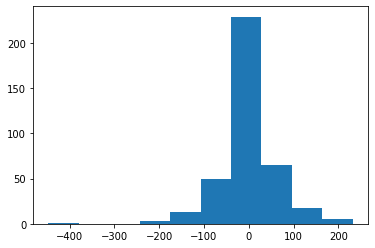

In [91]:
plt.hist(cv_label2.coef_.reshape(-1))

In [92]:
model1.model.coef_

array([[  20.96312716,  -79.07128255,   11.66483233,   80.89987241,
         -43.80537113,   64.25767144,  219.23530437,   22.93554177,
         265.36746854,  -33.54146824, -196.88350417,   35.95572866,
          99.85359265,   23.16084763,  -91.41195093,   22.29117439,
         -55.74464263,    7.28333537,  -51.68657628,   20.49341137,
        -105.09392732,   -1.84311876,  -78.87131962,  -42.52253822,
         -62.60578366, -149.05189341,  -83.43678992,    1.67566844,
         -60.10865765,  -56.06082565,  -63.95800266,   73.28256726,
          -7.44540734,  182.74363946, -139.9036988 ,   -6.16706125,
         304.17830098,  -18.9391462 ,  -95.16912285,  -74.88951623,
         158.21065363,   17.16033088,  -83.99724088,  184.48995308,
        -192.13903726, -114.3753671 ,   46.24572781,  128.37314703,
          81.23557407,  -73.74160903,  372.75343435,   37.51757257,
          -2.45943445,   46.63488526,   92.40010019,  121.45467201,
         -72.95402334,   -3.38002643,  202.00664

In [93]:
model1.model.intercept_

array([-14.63695404])

In [94]:
model1.predict_proba(proj_emb_dataset.samples[4].reshape(1, -1))

-0.0033285900019394223 0.12290091089093758


array([[0.99272931, 0.00727069]])

In [96]:
model2.predict_proba(proj_emb_dataset.samples[2].reshape(1, -1))

-0.0033285900019394223 0.12290091089093758


array([[1.03398938e-22, 3.10317335e-13, 2.11941341e-07, 5.54606938e-15,
        9.99999788e-01, 1.97000441e-12]])

In [208]:
submit = dataset.LabeledDataset.merge(
    pub_test_predictions, private_test_predictions)

In [198]:
submit.labels[:, 0] = np.array([1 - float(x) for x in submit.labels[:, 0]])

In [209]:
submit.labels[:10]

array([['0.26182865573803904', '6'],
       ['0.9999469809004441', '30'],
       ['0.994685582236025', '30'],
       ['0.9996005861276018', '30'],
       ['0.2689433565112792', '6'],
       ['0.003515667459942362', '20'],
       ['0.9612760169881223', '30'],
       ['0.0009252600656490806', '20'],
       ['0.9149720511722139', '3'],
       ['0.010044656387843687', '1']], dtype='<U32')

In [210]:
submit.labels[-10:]

array([['0.0005731891620759526', '10'],
       ['0.007762388837964359', '3'],
       ['0.00016210230550260034', '3'],
       ['0.9916921415277111', '1'],
       ['0.8095735724138696', '6'],
       ['0.9977790102031364', '20'],
       ['0.9722228118533371', '6'],
       ['8.10601035946809e-05', '3'],
       ['0.9889794580294028', '1'],
       ['0.022498591978145147', '10']], dtype='<U32')

In [211]:
dataset.dataset2submit_csv(submit,
    "../submits/1:log_reg2:log_reg_on_tsne_label_over_proj64_normalized_crop_64_seed_0_mobilenet_v3_small_embds_refit_false_cv_10.csv")


In [127]:
submit.tags.shape

(16564,)

In [128]:
submit.samples.shape

(16564, 1000)

In [129]:
pub_test_predictions.tags.shape, pub_test_predictions.samples.shape

((1502,), (1502, 1000))

In [130]:
private_test_predictions.tags.shape, private_test_predictions.samples.shape

((15062,), (15062, 1000))

In [244]:
model = applier.mobilenet_v3_small
model.train(False)

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [245]:
torch.save(model.state_dict(), "mobilenet_state_dict")

In [246]:
import torchvision
model2 = mobilenet_v3_small()

In [247]:
model2.load_state_dict(torch.load("mobilenet_state_dict"))

<All keys matched successfully>

In [248]:
np.random.seed(0)
t = np.random.random((1,3,500,500))
model2.train(False)
print(np.mean(t), np.std(t))
with torch.no_grad():
    res = model2(torch.Tensor(t)).detach().numpy()
print(np.mean(res), np.std(res))

0.5002803215266387 0.2887019402063319
0.46069193 1.7000295


In [249]:
np.random.seed(0)
t = np.random.random((1,3,500,500))
model.train(False)
print(np.mean(t), np.std(t))
with torch.no_grad():
    res = model(torch.Tensor(t)).detach().numpy()
print(np.mean(res), np.std(res))

0.5002803215266387 0.2887019402063319
0.46069193 1.7000295


In [214]:
model

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [231]:
import torchvision
mobilenet = torchvision.models.mobilenet_v3_small()
mobilenet.load_state_dict(torch.load("mobilenet_state_dict"))

np.random.seed(0)
t = np.random.random((1,3,500,500))
model2.train(False)
print(np.mean(t), np.std(t))
with torch.no_grad():
    res = mobilenet(torch.Tensor(t)).detach().numpy()
print(np.mean(res), np.std(res))



import time
start = time.time()
for i in np.arange(10):
    t = np.random.random((32,3,500,500))
    with torch.no_grad():
        res = mobilenet(torch.Tensor(t)).detach().numpy()
    
print('OK, run {}s'.format(time.time() - start))

0.5002803215266387 0.2887019402063319
3.4595482 0.81053764
OK, run 25.1478328704834s


In [242]:
import sys

sys.path.append('..')
from submition_track2.test_in_submit.mobilenet_v3 import mobilenet_v3_small

In [243]:
mobilenet = mobilenet_v3_small()